In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import random
import torch.optim as optim
from google.colab import drive
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
!pip install mido
import mido
!pip install pretty_midi
import pretty_midi as pm
drive.mount("/drive")
!pip install librosa
import librosa
!pip install pypianoroll
import pypianoroll
import numpy as np
import sys
import os

np.set_printoptions(threshold=sys.maxsize)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 1.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 96.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592303 sha256=65fdcf9bdb08478dec206bdee9050be6f71cb1650098887280c3383dc25e2739
  Stored in directory: /root/.cache/pip/wheels/75/ec/20/b8e937a5bcf1de547ea5ce465db7de7f6761e15e6f0a01e25f
Successfully built pretty_midi
Mounted at /drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
data = []
input = []
output = []

data = os.listdir("/drive/My Drive/nottingham")
print(len(data))

1022


In [ ]:
def shrink_matrix(matrix):
    new_matrix = np.empty((0, matrix.shape[1]), matrix.dtype)

    for i, row in enumerate(matrix):

        # Check if the current row index is divisible by 120
        if i % 6 == 0:

            # If it is, append the row to the new matrix
            new_matrix = np.vstack((new_matrix, row))
    return new_matrix

In [ ]:
def shrink_matrix_o(matrix):
    new_matrix = np.empty((0, matrix.shape[1]), matrix.dtype)

    for i, row in enumerate(matrix):

        # Check if the current row index is divisible by 120
        if i % 24 == 0:

            # If it is, append the row to the new matrix
            new_matrix = np.vstack((new_matrix, row))
    return new_matrix

In [ ]:
def pad_matrix(matrix):
  new_matrix = np.empty((0, matrix.shape[1]), matrix.dtype)

  for row in matrix:
    for i in range(6):
      new_matrix = np.vstack((new_matrix, row))
  return new_matrix

In [ ]:
def pad_matrix_o(matrix):
  new_matrix = np.empty((0, matrix.shape[1]), matrix.dtype)

  for row in matrix:
    for i in range(24):
      new_matrix = np.vstack((new_matrix, row))
  return new_matrix

In [ ]:
def filter_notes(matrix):
    # Get the number of rows in the matrix
    num_rows = matrix.shape[0]
    
    # Create a new matrix filled with zeros to store the output
    output_matrix = np.zeros_like(matrix)
    
    # Loop over each row of the input matrix
    for i in range(num_rows):
        # Get the current row of the matrix
        row = matrix[i, :]
        
        # Find the indices of the 3 largest values in the row
        indices = np.argpartition(row, -3)[-3:]
        
        # Set all elements in the row to 0 except for the 3 largest values
        row[row < row[indices].min()] = 0
        
        # Assign the modified row to the corresponding row in the output matrix
        output_matrix[i, :] = row
    
    return output_matrix


#m = np.array([[0, 5, 8, 2, 1], [9, 8, 7, 4, 10], [6, 5, 5, 3, 4]])
#print(filter_notes(m))


In [ ]:
#DATA PROCESSING
tempo = []
input = []
output = []
name = []

for path in data:
    midi = pypianoroll.read('/drive/My Drive/nottingham/' + path)
    #print(path)
    #print(vocal)
    vocal = midi.tracks[0]
    piano = midi.tracks[1]
    vocal.binarize()
    vocalpr = shrink_matrix(vocal.pianoroll[:,22:109])
    piano.binarize()
    pianopr = shrink_matrix_o(piano.pianoroll[:,22:109])
    for i in range(len(vocalpr) // 64):
      new_matrix = vocalpr[i*64:(i+1)*64,:]/80
      input.append(new_matrix)
      new_matrix = pianopr[i*16:(i+1)*16, :]/80
      output.append(new_matrix)
      tempo.append(midi.tempo)
      name.append(path + str(i))

/usr/local/lib/python3.9/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [ ]:
print(len(tempo), len(input), len(output), len(name))

7368 7368 7368 7368


In [ ]:
from sklearn.model_selection import train_test_split
input = np.array(input)
output = np.array(output)
name = np.array(name)
tempo = np.array(tempo)
input , input_test , output , output_test , name , name_test , tempo , tempo_test = train_test_split(input , output, name , tempo , test_size=0.2, random_state=10)

print(input.shape)


input = input[:,np.newaxis , :]
input_test= input_test[:,np.newaxis , :]
input_test = torch.Tensor(input_test)
print(output.shape)
output = output[:, np.newaxis,:]

input = torch.Tensor(input)
output = torch.Tensor(output)
print(output.shape)

input_dataset = TensorDataset(input)
output_dataset = TensorDataset(output)



#print(input_dataset.tensors)

dataloader = DataLoader(dataset = output_dataset , batch_size= 500)
dataloaderG = DataLoader(input_dataset, batch_size= 500 )

(5894, 64, 87)
(5894, 16, 87)
torch.Size([5894, 1, 16, 87])


<ipython-input-10-11b62a8bde18>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tempo = np.array(tempo)


In [ ]:


manualSeed = 3085
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


batchsize = 32
inputsize = 4
smallest_note =16
note_range = 129
epochs = 100
rate = 0.0001
rateD = 0.00001
adam_beta = 0.5
alpha = 0.01


#device = torch.device("cuda:0" if (torch.cuda.is_available() and 1 > 0) else "cpu")
device = torch.device("cuda")

# Sample Data 4 bars smallest note is 16th note:
# Mary had a little lamb 
#   
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
  def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( 1, 4*4 , 8, stride=1, dilation=1 , bias=False),
            nn.BatchNorm2d(4*4 ),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(4*4 , 8, 4, stride=1, dilation=1,  bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( 8, 4 * 2, 2, stride=1,  dilation=1, bias=False),
            nn.BatchNorm2d(4 * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( 4 * 2, 4, 4,stride=1,  dilation=1, bias=False),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( 4, 1, 2, stride=(1,1),  dilation=(1,1) ,bias=True),
            nn.Sigmoid()
        )
  def forward(self, input):
        out = self.main(input)
        return out


generator = Generator(1).to(device)
generator.apply(weights_init)

# Print the model
print(generator)


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(1, 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Conv2d(2, 2 * 2, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(2 * 2),
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.Conv2d(2 , 2 * 4, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(2 * 4),
            # nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(2, 2 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(2 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(2 * 4, 1, 4, 1, 0, bias=False),
            nn.Flatten(),
            nn.Linear(18 ,1),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)

discriminator = Discriminator(1).to(device)

discriminator.apply(weights_init)






Random Seed:  3085
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(1, 16, kernel_size=(8, 8), stride=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 8, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(8, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (10): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(4, 1, kernel_size=(2, 2), stride=(1, 1))
    (13): Sigmoid()
  )
)


Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(2, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(8, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=18, out_features=1, bias=True)
    (8): Sigmoid()
  )
)

In [ ]:
def n_pitches_used(matrix):
    # Check that the matrix has the correct dimensions
    
    # Reshape the matrix to have 4 bars per row
    reshaped_matrix = matrix.reshape((matrix.shape[0],4, 4, 87))
    
    # Compute the number of unique pitches used per bar
    unique_pitches = torch.sum(torch.count_nonzero(reshaped_matrix, axis=2), axis=1 , dtype = torch.float)
    
    # Return the average number of unique pitches used per bar
    return torch.mean(unique_pitches)

In [ ]:
class GeneratorLoss(nn.Module):
  def __init__(self):
        super(GeneratorLoss, self).__init__()

  def forward(self, output, target):
      mask = np.zeros(output.shape)
      mask[:,:,0:15,:] = 1
      mask[:,:,-20:,:] = 1
      
      return  alpha * n_pitches_used(output)

In [ ]:

criterion = nn.BCELoss()

real_label = 1.
fake_label = 0.
gen_criterion = GeneratorLoss()

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(discriminator.parameters(), lr=rateD, betas=(adam_beta, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=rate, betas=(adam_beta, 0.999))

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(epochs):
    # For each batch in the dataloader
    for i, dataT in enumerate(zip(dataloader,dataloaderG), 0):
        data, dataG = dataT

        discriminator.zero_grad()

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        outputt = discriminator(real_cpu).view(-1)

        errD_real = criterion(outputt, label)

        errD_real.backward()
        D_x = outputt.mean().item()

        inputt = dataG[0].to(device)

        fake = generator(inputt)[:,:,:16,:87]


        label.fill_(fake_label)

        outputt = discriminator(fake.detach()).view(-1)


        errD_fake = criterion(outputt, label)

        errD_fake.backward()
        D_G_z1 = outputt.mean().item()

        errD = errD_real + errD_fake

        optimizerD.step()


        generator.zero_grad()
        label.fill_(real_label)  
        outputt = discriminator(fake).view(-1)


        errG = criterion(outputt, label) + gen_criterion(fake, label)
        
        errG.backward()
        D_G_z2 = outputt.mean().item()
        
        optimizerG.step()

        if(errG.item() < 0):
          break
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1

Starting Training Loop...
[0/100][0/12]	Loss_D: 1.3971	Loss_G: 0.7989	D(x): 0.5239	D(G(z)): 0.5279 / 0.5279
[0/100][1/12]	Loss_D: 1.3970	Loss_G: 0.7990	D(x): 0.5239	D(G(z)): 0.5279 / 0.5278
[0/100][2/12]	Loss_D: 1.3971	Loss_G: 0.7991	D(x): 0.5238	D(G(z)): 0.5278 / 0.5278
[0/100][3/12]	Loss_D: 1.3963	Loss_G: 0.7991	D(x): 0.5242	D(G(z)): 0.5278 / 0.5278
[0/100][4/12]	Loss_D: 1.3969	Loss_G: 0.7991	D(x): 0.5239	D(G(z)): 0.5278 / 0.5278
[0/100][5/12]	Loss_D: 1.3972	Loss_G: 0.7992	D(x): 0.5237	D(G(z)): 0.5278 / 0.5277
[0/100][6/12]	Loss_D: 1.3963	Loss_G: 0.7992	D(x): 0.5242	D(G(z)): 0.5278 / 0.5277
[0/100][7/12]	Loss_D: 1.3965	Loss_G: 0.7992	D(x): 0.5241	D(G(z)): 0.5278 / 0.5277
[0/100][8/12]	Loss_D: 1.3960	Loss_G: 0.7993	D(x): 0.5243	D(G(z)): 0.5277 / 0.5277
[0/100][9/12]	Loss_D: 1.3971	Loss_G: 0.7993	D(x): 0.5237	D(G(z)): 0.5277 / 0.5277
[0/100][10/12]	Loss_D: 1.3962	Loss_G: 0.7994	D(x): 0.5241	D(G(z)): 0.5277 / 0.5276
[0/100][11/12]	Loss_D: 1.3963	Loss_G: 0.7994	D(x): 0.5240	D(G(z)): 0.52

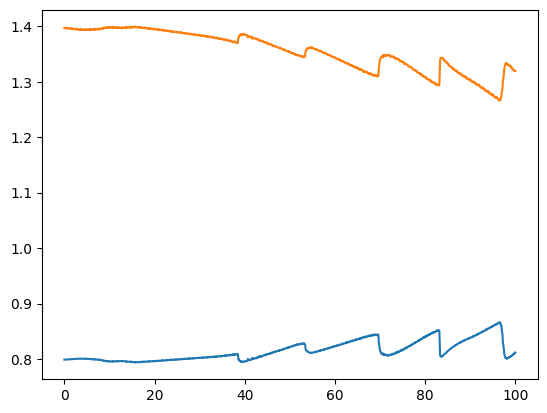

In [ ]:
plt.plot( np.linspace(0,epochs ,len(G_losses)) ,np.array(G_losses) )
plt.plot( np.linspace(0,epochs ,len(G_losses)) ,np.array(D_losses) )
plt.show()

In [ ]:
torch.save(generator , "/drive/My Drive/generator_npitches" )
torch.save(discriminator, "/drive/My Drive/discriminator_npitches" )


In [ ]:
def n_pitches_used_out(matrix):
    # Check that the matrix has the correct dimensions
    
    # Reshape the matrix to have 4 bars per row

    
    # Compute the number of unique pitches used per bar
    unique_pitches = torch.sum(torch.count_nonzero(matrix, axis=1), axis=1 , dtype = torch.float)
    
    # Return the average number of unique pitches used per bar
    return torch.mean(unique_pitches)

reelsh-l35.mid13


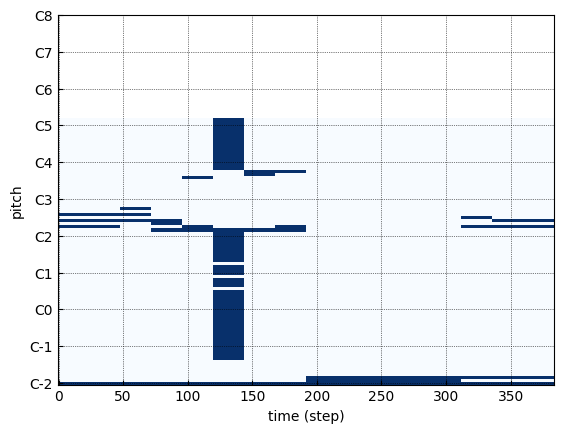

In [ ]:
d = 50
result_array = generator(input_test[d:d+1].to(device)).cpu().detach().numpy()

result_array = result_array[0,0,:16,:87]

# print(n_pitches_used_out(torch.tensor(result_array)))
# for i in range(result_array.shape[0]):
#   result_array[i,result_array[i,:] != np.partition(result_array[i,:] , 3)] = 0
# result_array[result_array < 0.75] = 0

# result_array = pad_matrix(result_array)

result_array = filter_notes(result_array)
# print(n_pitches_used_out(torch.tensor(result_array)))
result_array = pad_matrix_o(result_array)
result_array[:,0] = 1
pp = pypianoroll.BinaryTrack(pianoroll = result_array)
pp.plot()

out = pypianoroll.Multitrack()
out.tempo = tempo_test[d]
out.append(pp)
pypianoroll.write("/drive/My Drive/test" + name_test[d]+ ".mid" , out)
print(name_test[d])